In [13]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import pyperclip

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

# disable 'show more outputs' nonsense
from IPython.core.interactiveshell import InteractiveShell

# Always display all outputs in a cell
InteractiveShell.ast_node_interactivity = "all"


In [14]:
print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")


requests        2.32.3
BeautifulSoup   4.13.3


In [15]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [16]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


ProfileViewDetailed(did='did:plc:qomkdnxrqw3gkbytdxea5z65', handle='skynetandchill.com', associated=ProfileAssociated(chat=ProfileAssociatedChat(allow_incoming='following', py_type='app.bsky.actor.defs#profileAssociatedChat'), feedgens=0, labeler=False, lists=0, starter_packs=0, py_type='app.bsky.actor.defs#profileAssociated'), avatar='https://cdn.bsky.app/img/avatar/plain/did:plc:qomkdnxrqw3gkbytdxea5z65/bafkreihi55ddvmohg6dztiwlkwdbts5fd76iaenef2sriacvj7ibtezagi@jpeg', banner='https://cdn.bsky.app/img/banner/plain/did:plc:qomkdnxrqw3gkbytdxea5z65/bafkreigu723bmkba3mff4krhcrrf7b5zw2svixwbvtj54v5ho64o2xpmzu@jpeg', created_at='2024-02-12T00:15:55.099Z', description='Daily artificial intelligence news, lovingly curated by man and machine. https://www.skynetandchill.com\n\nNeo-Luddite AI maven. On a long enough timeline, p(doom) for everything goes to 1.', display_name='SkynetAndChill.com', followers_count=323, follows_count=347, indexed_at='2024-11-21T15:40:08.470Z', joined_via_starter_p

In [17]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [18]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [19]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [20]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [21]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [22]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 

 <br /> 

197618

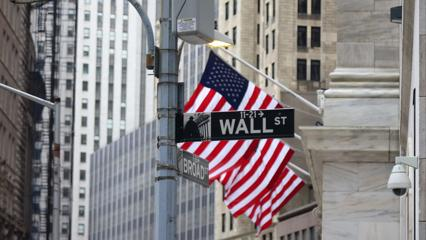

[AI should help eliminate the 3am 'please fix' emails to center a Powerpoint table, but junior bankers still need to immerse themselves and put in their 10,000 hours of motivated practice to become seniors.](https://www.ft.com/content/e4eb5f3b-9c3a-445a-bbce-26455ea83f7c)

___

655256

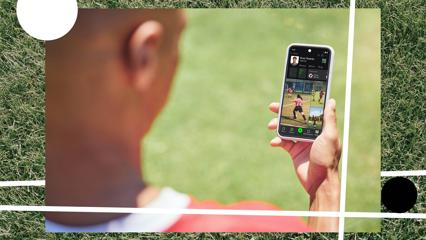

[Youngsters in Brazil hoping to be the next Neymar try to get spotted by using video apps that employ mass talent-scouting systems](https://www.ft.com/content/94e1654a-c0e3-405d-92fd-82ef10f57ab7)

___

127978

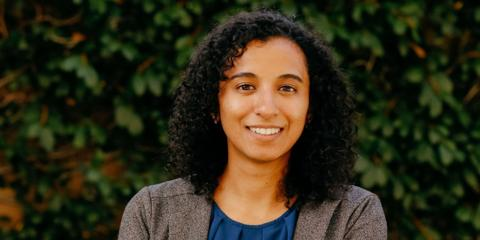

[Samaya AI, startup selling AI tools to Wall Street, gets \\$43.5 million in new funding](https://fortune.com/2025/05/14/samaya-ai-startup-financial-services-raises-43-5-million-vc-funding/) - Fortune

___

[China Accuses US of ‘Unilateral Bullying’ on Huawei AI Chips](https://www.bloomberg.com/news/articles/2025-05-15/china-accuses-us-of-unilateral-bullying-on-huawei-ai-chips)

___

[Multi-agent systems can start to create their own language and social norms on their own](https://uk.finance.yahoo.com/news/ai-systems-start-create-own-215931327.html?guccounter=1)

___

73417

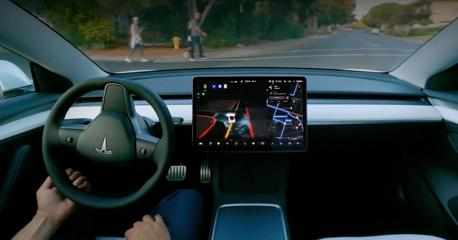

[Tesla has yet to start testing its robotaxi service without a driver weeks before launch, will lean heavily on safety drivers and tele-operation despite years of FSD hype.](https://electrek.co/2025/05/14/tesla-yet-start-testing-robotaxi-service-without-driver-weeks-before-launch/) - Electrek

___

54573

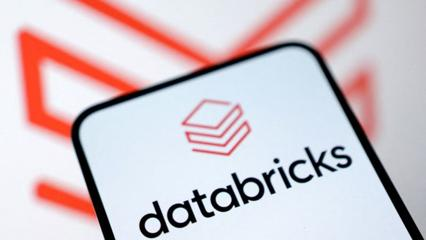

[Databricks to buy serverless cloud Postgres startup Neon for \\$1 billion to boost AI-agent development](https://www.channelnewsasia.com/business/databricks-buy-neon-1-billion-boost-ai-agent-development-5129321) - CNA

___

180918

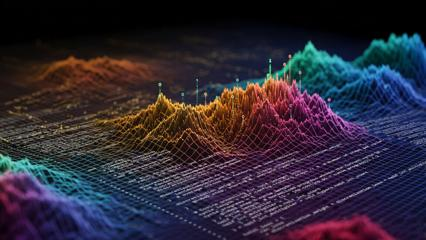

[Google DeepMind creates super-advanced AI that can invent new algorithms](https://arstechnica.com/ai/2025/05/google-deepmind-creates-super-advanced-ai-that-can-invent-new-algorithms/) - Ars Technica

___

31033

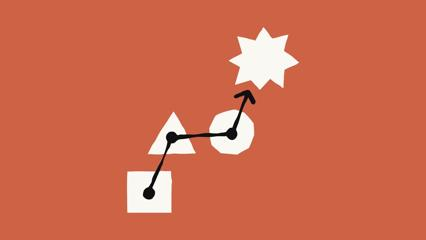

[Claude AI is getting a big Reasoning upgrade: Everything you should know](https://bgr.com/tech/claude-ai-is-about-to-get-new-thinking-powers-that-let-it-go-back-to-reasoning-to-help-you-out/) - BGR

___

76567

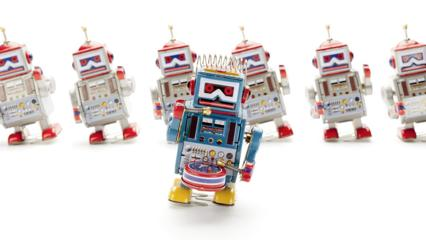

[OpenAI adds GPT-4.1 to ChatGPT amid complaints over confusing model lineup](https://arstechnica.com/ai/2025/05/some-chatgpt-users-now-face-9-ai-models-to-choose-from-after-gpt-4-1-launch/) - Ars Technica

___

name 'httplib' is not defined


[LLMs performance degradation in multi-turn conversations](https://arxiv.org/abs/2505.06120) - arXiv.org

___

477118

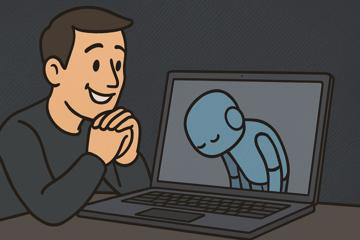

[Beyond sycophancy: DarkBench exposes six hidden ‘dark patterns’ lurking in today’s top LLMs](https://venturebeat.com/ai/darkness-rising-the-hidden-dangers-of-ai-sycophancy-and-dark-patterns/) - VentureBeat

___

114711

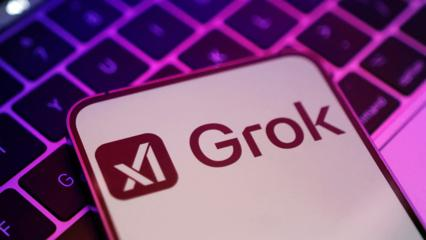

[Elon Musk’s AI chatbot shared ‘white genocide’ tropes on X, raising moderation and political bias concerns.](https://www.ft.com/content/37416a0e-8f35-45af-9ace-2cf4c973daa5)

___

Alignment is hard

When the smartest people in the world do everything perfectly AI *might* work some of the time. When one idiot attacks it it almost certainly fails.

There is always a jailbreak 

Murphy’s laws of AI

WTF is this

big if true

87749

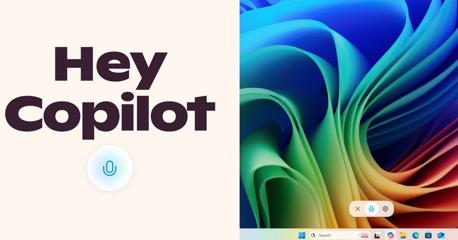

[Microsoft starts testing  ‘Hey, Copilot!’ in Windows. Don’t call me Cortana!](https://www.theverge.com/news/667167/windows-hey-copilot-ai-wake-word-voice-activation) - The Verge

___

[Before entrusting AI agents with government power, it’s essential that they have guardrails requring them to obey the law—even when instructed not to.](https://www.lawfaremedia.org/article/ai-agents-must-follow-the-law) - Default

___

Who is the neurotic 'fat shot' businessman Trump referred to? Grok has a suspect

i am experiencing trauma

258010

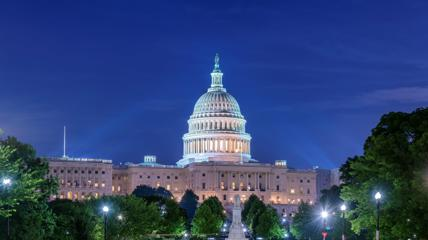

[Big Tech-championed 10-year pause on state rules for artificial intelligence still moving forward.](https://gizmodo.com/republicans-pander-to-big-tech-with-proposed-10-year-ban-on-state-ai-regulations-2000602076) - Gizmodo

___

30312

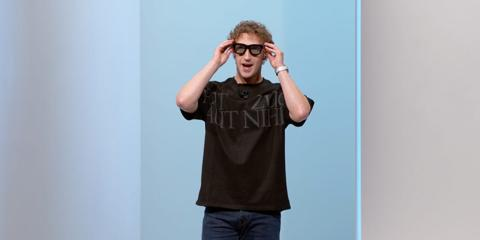

[Robot trainer is a growing job category](https://www.businessinsider.com/meta-project-warhol-avatar-data-metaverse-smart-glasses-2025) - Business Insider

___

187342

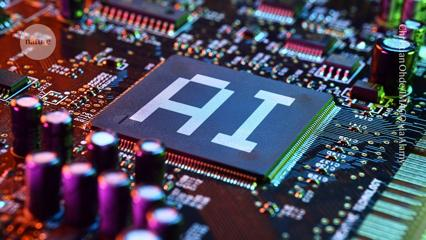

[DeepMind annnounces ‘spectacular’ general-purpose science AI](https://www.nature.com/articles/d41586-025-01523-z)

___

98331

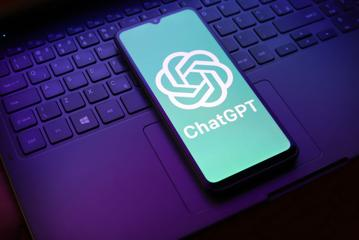

[OpenAI brings its GPT-4.1 models to ChatGPT, adding confusion](https://techcrunch.com/2025/05/14/openai-brings-its-gpt-4-1-models-to-chatgpt/) - TechCrunch

___

[OpenAI launches safety website, promises greater transparency about its safety efforts.](https://openai.com/safety/evaluations-hub/)

___

[AI powers Expedia’s marketing evolution](https://openai.com/index/expedia-jochen-koedijk/)

___

22773

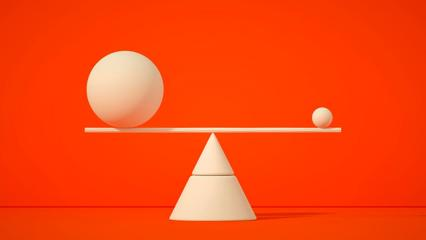

[Gen AI use at work saps our motivation even as it boosts productivity, new research shows](https://www.zdnet.com/article/gen-ai-use-at-work-saps-our-motivation-even-as-it-boosts-productivity-new-research-shows/) - ZDNET

___

87155

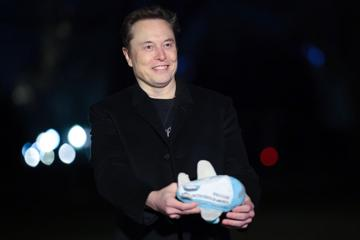

[Grok AI Is Replying to Random Tweets With Information About 'White Genocide'](https://gizmodo.com/grok-ai-is-replying-to-random-tweets-with-information-about-white-genocide-2000602243) - Gizmodo

___

[Anthropic’s Upcoming Models Will Think… And Think Some More](https://www.theinformation.com/articles/anthropics-upcoming-models-will-think-think)

___

133349

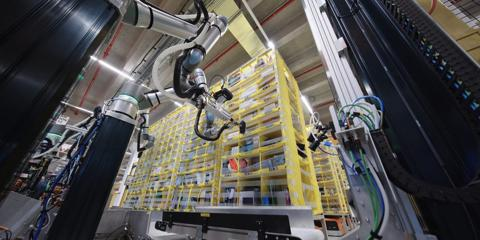

[Amazon sees warehouse robots 'flattening' its hiring curve, according to internal document](https://www.businessinsider.com/amazon-warehouse-robots-flatten-hiring-curve-2025-5) - Business Insider

___

[AI blamed for man's journey from \\$150K-a-year software engineering job to being rejected from 800 jobs and bing forced to DoorDash and live in a trailer to make ends meet](https://www.yahoo.com/news/software-engineer-lost-150k-job-090000839.html?guccounter=1&guce_referrer=aHR0cHM6Ly9tYWlsLmdvb2dsZS5jb20v&guce_referrer_sig=AQAAABMoP-fPrmzuiPb2F9hxIJ_4pgkio5xyBrlhAmWWYuhuFaVTkNNilgr0R_m0xMG6H0E-8nPg23raxnc7DsbBe3rTbPEA66rmbfILdK6TJkILf1bCZ2DW7pqxvSWCDZAcBT1uyfuRzO5nF7CoIxDCJoRdsDnw9a-PGuLtkGzxCbNa)

___

[Microsoft Layoffs Hit Coders Hardest With AI Costs on the Rise](https://www.bloomberg.com/news/articles/2025-05-14/microsoft-layoffs-hit-software-engineers-as-industry-touts-ai-savings)

___

199736

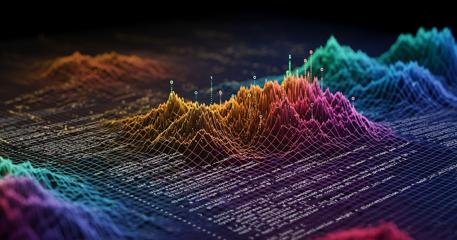

[AlphaEvolve: A Gemini-powered coding agent for designing advanced algorithms](https://deepmind.google/discover/blog/alphaevolve-a-gemini-powered-coding-agent-for-designing-advanced-algorithms/) - Google DeepMind

___

[Is AI Enhancing Education or Replacing It?](https://www.chronicle.com/article/is-ai-enhancing-education-or-replacing-it)

___

Strange things afoot at the Nazi Circle K, did someone push code to answer this specific question and screw up, did an intern make some kind of protest?

704384

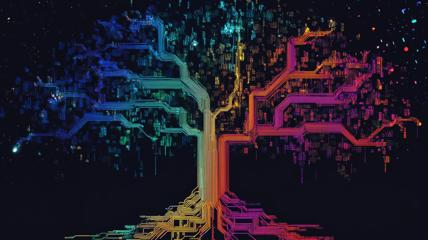

[Meet AlphaEvolve, the Google AI that writes its own code—and just saved millions in computing costs](https://venturebeat.com/ai/meet-alphaevolve-the-google-ai-that-writes-its-own-code-and-just-saved-millions-in-computing-costs/) - VentureBeat

___

176529

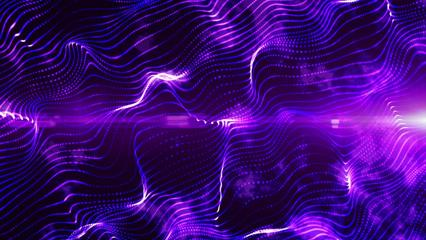

[Tech leaders are rushing to deploy agentic AI, study shows](https://www.zdnet.com/article/new-poll-shows-tech-leaders-rushing-to-deploy-agentic-ai/) - ZDNET

___

62578

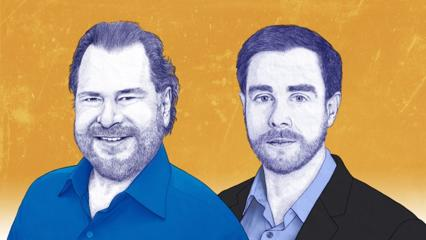

[Marc Benioff of Salesforce: ‘You’re going to have to throw a lot against the wall before you figure out what sticks’](https://www.ft.com/content/c4efe4d3-15d7-44b6-b93f-497f1368ce48)

___

[Using AI to help dig through survey data](https://www.fastcompany.com/91333723/morning-consult-launches-an-ai-tool-makes-survey-data-a-breeze)

___

93088

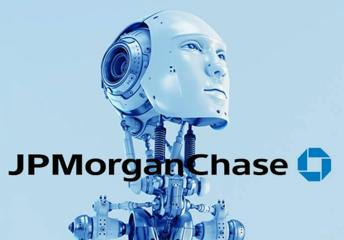

[Reinforcement learning and other algos to trade more efficiently](https://hackernoon.com/this-is-how-jp-morgan-trades-with-ai)

___

[Your A.I. Radiologist Will Not Be With You Soon](https://www.nytimes.com/2025/05/14/technology/ai-jobs-radiologists-mayo-clinic.html)

___

278073

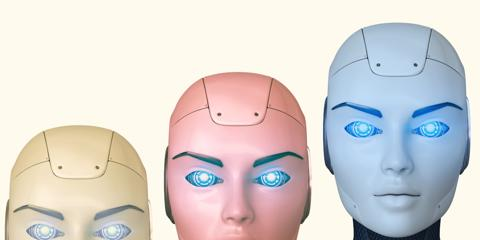

[On the Very Real Dangers of the Artificial Intelligence Hype Machine](https://lithub.com/on-the-very-real-dangers-of-the-artificial-intelligence-hype-machine/) - Literary  Hub

___

33287

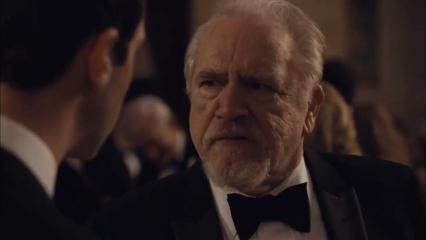

[what to say](https://www.youtube.com/watch?v=-bu5f1Zr3_s) - YouTube

___

88488

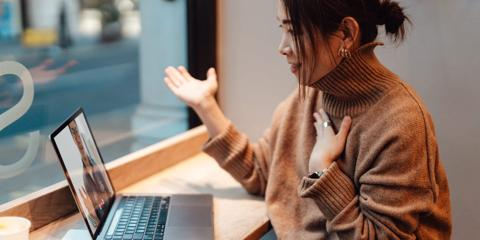

[What to say and what to wear when your job interviewer is a robot](https://www.businessinsider.com/job-interviews-ai-robots-how-to-prepare-keywords-advice-recruitment-2025-5) - Business Insider

___

155727

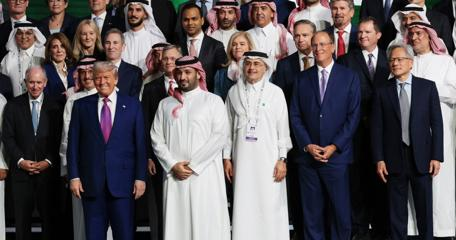

[Ass-kissing pays: Nvidia’s flattery of Trump wins reversal of AI chip limits and a Huawei clampdown.](https://www.theverge.com/news/666605/nvidias-flattery-of-trump-wins-reversal-of-ai-chip-limits-and-a-huawei-clampdown) - The Verge

___

[The Professors Are Using ChatGPT, and Some Students Aren’t Happy About It](https://www.nytimes.com/2025/05/14/technology/chatgpt-college-professors.html)

___

[Everyone's deploying AI, but no one's securing it – what could go wrong?](https://www.theregister.com/2025/05/14/cyberuk_ai_deployment_risks/)

___

94411

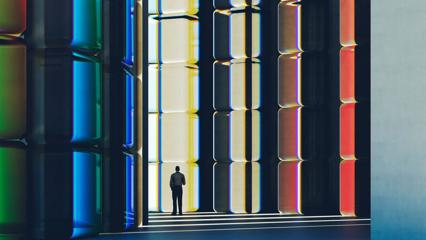

[Who wants to be a chief AI officer? A new career path emerges](https://www.zdnet.com/article/who-wants-to-be-a-chief-ai-officer-a-new-career-path-emerges/) - ZDNET

___

466600

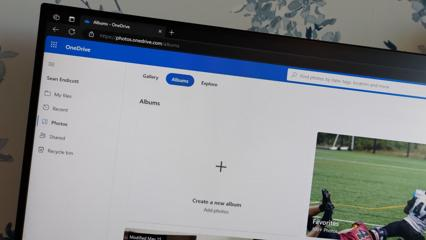

[You can now use ChatGPT's Deep Research AI to find and analyze Microsoft OneDrive and SharePoint files](https://www.windowscentral.com/software-apps/chatgpt-deep-research-to-onedrive-sharepoint) - Windows Central

___

107453

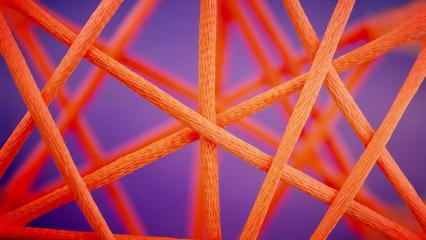

[Zapier can connect AI to thousands of apps to make no-code agents](https://www.zdnet.com/article/meet-the-most-important-ai-tool-that-no-one-is-talking-about-but-everyone-needs/) - ZDNET

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [23]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n\n <br /> "))

md_output = ""

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            md_output += f"![image]({img_url})\n\n"
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        md_output += display_str + "\n\n"
        display(Markdown("___"))
        md_output += "___" + "\n\n"

    else:
        display(Markdown(post_str))
        md_output += f"{post_str}" + "\n\n"

md_output += f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"
display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))


In [24]:
edit_prompt = """
# Role
You are a newsletter editor.

# Task
Reorder the items in the Markdown newsletter supplied below so that:
1. They appear from **most important** to **least important**.
2. Items that cover similar topics, companies, themes, or storylines are placed **next to each other** (i.e., logically grouped).

# How to judge importance
- Lead with stories that have the broadest impact on the tech/AI industry, major financial stakes, or significant societal implications.
- Follow with narrower‑scope or opinion pieces.
- End with lighter or human‑interest items.

# How to group
- If two or more items discuss the same organization, technology, policy debate, or overarching trend, keep them together.
- Within any group, preserve the original order unless a clear hierarchy (e.g., breaking news vs. commentary) makes a different order more logical.

# Output rules
- Return **only** the reordered newsletter, in valid Markdown.
- Do **not** alter the wording of individual items (other than correcting spelling and punctuation, and normalizing spaces or line breaks as needed).
- Insert one blank line between each logical group for readability.
- Do not output anything other than the newsletter itself—no headers, explanations, or commentary.

# Newsletter to reorder
"""

# from openai import OpenAI
# client = OpenAI() 
# response = client.chat.completions.create(
#     model="o3-mini", 
#     messages=[{"role": "user", "content": edit_prompt + md_output}],
# )

# response_str = response.choices[0].message.content

# edit this, deleting older items and paste into o3
pyperclip.copy(edit_prompt + md_output)
print(edit_prompt + md_output)


# Role
You are a newsletter editor.

# Task
Reorder the items in the Markdown newsletter supplied below so that:
1. They appear from **most important** to **least important**.
2. Items that cover similar topics, companies, themes, or storylines are placed **next to each other** (i.e., logically grouped).

# How to judge importance
- Lead with stories that have the broadest impact on the tech/AI industry, major financial stakes, or significant societal implications.
- Follow with narrower‑scope or opinion pieces.
- End with lighter or human‑interest items.

# How to group
- If two or more items discuss the same organization, technology, policy debate, or overarching trend, keep them together.
- Within any group, preserve the original order unless a clear hierarchy (e.g., breaking news vs. commentary) makes a different order more logical.

# Output rules
- Return **only** the reordered newsletter, in valid Markdown.
- Do **not** alter the wording of individual items (other than correcti

In [14]:
import pyperclip
pyperclip.copy(edit_prompt + md_output)



In [15]:
pyperclip.copy( md_output)


In [ ]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

In [ ]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


In [ ]:
from typing import TypedDict, Annotated

class Point2D(TypedDict, total=False):
    x: int
    y: int
    label: str

a: Point2D = {'x': 1, 'y': 2, }  # 


In [ ]:
a

In [ ]:
b



In [ ]:
```mermaid
flowchart LR

A[Hard] -->|Text| B(Round)
B --> C{Decision}
C -->|One| D[Result 1]
C -->|Two| E[Result 2]
